In [1]:
import datetime as dt
import math

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

import sys

sys.path.append("..")
# from tooling.enums import AssetClass, Index, Spot, StrikeSpread
# from tooling.fetch import fetch_option_data, fetch_spot_data
# from tooling.filter import find_atm, option_tool

from fetching_from_local_db.enums import AssetClass, Index, StrikeSpread
from fetching_from_local_db.fetch_from_db import (
    _fetch_batch,
    fetch_data,
    fetch_spot_data,
)

In [2]:
async def get_expiry(f_today):

    if (f_today <= dt.date(2024, 1, 25)) and (f_today >= dt.date(2024, 1, 18)):
        f_expiry = dt.date(2024, 1, 25)
    elif (f_today <= dt.date(2024, 1, 31)) and (f_today >= dt.date(2024, 1, 26)):
        f_expiry = dt.date(2024, 1, 31)
    elif (f_today <= dt.date(2024, 2, 22)) and (f_today >= dt.date(2024, 2, 29)):
        f_expiry = dt.date(2024, 2, 29)
    elif (f_today <= dt.date(2024, 3, 25)) and (f_today >= dt.date(2024, 3, 27)):
        f_expiry = dt.date(2024, 2, 27)
    elif f_today < dt.date(2023, 9, 1):
        days_to_thursday = (3 - f_today.weekday()) % 7
        nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
        f_expiry = nearest_thursday
        if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
            f_expiry = nearest_thursday - dt.timedelta(days=1)
    elif f_today >= dt.date(2023, 9, 1):
        if f_today.day < 24:
            days_to_wednesday = (2 - f_today.weekday()) % 7
            nearest_wednesday = f_today + dt.timedelta(days=days_to_wednesday)
            f_expiry = nearest_wednesday
            if nse.valid_days(
                start_date=nearest_wednesday, end_date=nearest_wednesday
            ).empty:
                f_expiry = nearest_wednesday - dt.timedelta(days=1)
        else:
            days_to_thursday = (3 - f_today.weekday()) % 7
            nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
            f_expiry = nearest_thursday
            if nse.valid_days(
                start_date=nearest_thursday, end_date=nearest_thursday
            ).empty:
                f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_finnifty(f_today):

    days_to_thursday = (1 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_nifty(f_today):

    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_midcpnifty(f_today):

    days_to_thursday = (0 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


import datetime as dt


async def get_monthly_expiry_nifty(input_date):
    # Get the last day of the current month
    current_month_last_day = (
        input_date.replace(day=28) + dt.timedelta(days=4)
    ).replace(day=1) - dt.timedelta(days=1)

    # Find the last Thursday of the current month
    last_thursday_current_month = current_month_last_day - dt.timedelta(
        days=(current_month_last_day.weekday() - 3) % 7
    )

    # Check if the current date is less than the last Thursday of the current month
    if input_date < last_thursday_current_month:
        last_thursday = last_thursday_current_month
    else:
        # If the current date has passed the last Thursday, find the last Thursday of the next month
        next_month = (input_date.month % 12) + 1
        next_month_year = input_date.year if next_month > 1 else input_date.year + 1

        # Get the last day of the next month (considering February correctly)
        if next_month == 2:  # February
            if next_month_year % 4 == 0 and (
                next_month_year % 100 != 0 or next_month_year % 400 == 0
            ):
                last_day_of_next_month = 29  # Leap year
            else:
                last_day_of_next_month = 28  # Non-leap year
        else:
            # Calculate the last day of the next month
            last_day_of_next_month = (
                dt.date(next_month_year, next_month, 1) + dt.timedelta(days=31)
            ).replace(day=1) - dt.timedelta(days=1)
            last_day_of_next_month = (
                last_day_of_next_month.day
            )  # Extract the day as an integer

        # Create a date for the last day of the next month
        last_day_of_next_month_date = dt.date(
            next_month_year, next_month, last_day_of_next_month
        )

        # Find the last Thursday of the next month
        last_thursday = last_day_of_next_month_date - dt.timedelta(
            days=(last_day_of_next_month_date.weekday() - 3) % 7
        )

    # Validate if the last Thursday is a trading day
    if nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
        # If it's a holiday, find the previous valid trading day
        last_thursday -= dt.timedelta(days=1)
        while nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
            last_thursday -= dt.timedelta(days=1)

    return last_thursday


async def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [3]:
# bnf_pandas = pd.read_csv("../data/bnf_min.csv")
bnf_pandas = pd.read_csv("../data/nifty.csv")
# bnf_pandas = pd.read_csv("../data/fin_min.csv")
# bnf_pandas = pd.read_csv("../data/midcp_min.csv")
# bnf_pandas = pd.read_csv("../data/sensex_min.csv")
# bnf_pandas = pd.read_csv("../data/bankex_min.csv")

In [4]:
# If Stocks Data ...
bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["datetime"])
bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# bnf_pandas

In [5]:
bnf = pl.DataFrame(bnf_pandas)
print(type(bnf))
# bnf

<class 'polars.dataframe.frame.DataFrame'>


In [6]:
bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")
bnf = bnf.with_columns(pl.col("index").alias("datetime"))

In [7]:
# bnf = bnf.rename({"open": "o", "high": "h", "low": "l", "close": "c", "volume": "v"})

In [8]:
def resample(data, timeframe, offset=None):
    agg_list = [
        pl.col("o").first().alias("o"),
        pl.col("h").max().alias("h"),
        pl.col("l").min().alias("l"),
        pl.col("c").last().alias("c"),
    ]
    if timeframe == '10m':
        offset = '5m'
    if "v" in data.columns:
        agg_list.append(pl.col("v").sum().alias("v"))
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(agg_list)
    )


In [9]:
# def generate_signals(df, n=5):
#     import numpy as np
#     import pandas as pd

#     # Ensure required columns are present
#     required_cols = {'o', 'h', 'l', 'c', 'datetime'}
#     if not required_cols.issubset(df.columns):
#         raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
#     # Ensure datetime is in datetime format
#     if not np.issubdtype(df['datetime'].dtype, np.datetime64):
#         df['datetime'] = pd.to_datetime(df['datetime'])
    
#     # Calculate the low of the previous n candles
#     df['Prev_N_Low'] = df['l'].rolling(window=n).min().shift(1)
    
#     # Generate sell signal
#     df['Sell Signal'] = df['c'] < df['Prev_N_Low']
    
#     # Drop intermediate columns if not needed
#     df.drop(columns=['Prev_N_Low'], inplace=True, errors='ignore')
    
#     return df


In [10]:
# USING SMA LOW for ENTRY
def generate_signals(df, st_num=3, ema=5, pct=0.9):
    """
    Calculate signals for reversal selling strategy with SMA-based condition.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with columns 'datetime', 'o', 'h', 'l', 'c', and optionally 'v'.
    st_num (int): Period for short-term SMA and low calculation.
    ema (int): Period for EMA calculation.
    pct (float): Percentage threshold for high price comparison.
    
    Returns:
    pd.DataFrame: DataFrame with additional columns 'Reversal Sell Signal' and tracking indicators.
    """
    # Ensure the DataFrame has the required columns
    required_columns = {'datetime', 'h', 'l', 'c'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Calculate short-term SMA of the lows
    df['SMA_Low'] = df['l'].rolling(window=st_num).mean().shift(1)
    
    # Calculate a very short-term EMA (e.g., 5-period)
    df['EMA_5'] = df['c'].ewm(span=ema, adjust=False).mean()
    
    # Calculate daily high till now
    df['daily_high_till_now'] = df.groupby(df['datetime'].dt.date)['h'].cummax()
    
    # Define Reversal Sell Signal
    df['Sell Signal'] = (
        (df['h'] > (pct * df['daily_high_till_now'].shift(1))) &  # Price is near or above the daily high
        (df['c'] < df['SMA_Low'])  # Close below SMA of the lows
    ).astype(int)
    
    return df


In [11]:
def generate_signals(df, st_num=3, ema=5, pct=0.9):
    """
    Calculate signals for reversal selling strategy.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with columns 'datetime', 'o', 'h', 'l', 'c', and optionally 'v'.
    
    Returns:
    pd.DataFrame: DataFrame with additional columns 'Reversal Sell Signal' and tracking indicators.
    """
    # Ensure the DataFrame has the required columns
    required_columns = {'datetime', 'h', 'l', 'c'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Calculate a 3-period high (short-term high)
    df['short_term_low'] = df['l'].rolling(window=st_num).min().shift(1)

    # Calculate a very short-term EMA (e.g., 5-period)
    df['EMA_5'] = df['c'].ewm(span=ema, adjust=False).mean()
    
    # Calculate daily high till now
    df['daily_high_till_now'] = df.groupby(df['datetime'].dt.date)['h'].cummax()
    
    # Define Reversal Sell Signal
    # df['Sell Signal'] = (
    #     (df['h'] > (pct*df['daily_high_till_now'].shift(1))) &  # Price is near or above the daily high
    #     (df['c'] < df['short_term_low']) &  # Closing below the short-term high (early weakness)
    #     (df['c'] < df['EMA_5'])  # Close below very short-term EMA for confirmation
    # ).astype(int)
    df['Sell Signal'] = (
        (df['h'] > (pct*df['daily_high_till_now'].shift(1))) &  # Price is near or above the daily high
        (df['c'] < df['short_term_low'])).astype(int)
    
    return df


In [12]:
data = bnf_pandas.copy()
# data['datetime'] = pd.to_datetime(data['datetime'].dt.date)
print(data["datetime"].tail())
trading_days_set = set(data["datetime"].dt.date)
# sorted(trading_days_set)

735722   2024-12-13 15:25:00
735723   2024-12-13 15:26:00
735724   2024-12-13 15:27:00
735725   2024-12-13 15:28:00
735726   2024-12-13 15:29:00
Name: datetime, dtype: datetime64[ns]


In [13]:
# GLOBAL VARIABLES

INSTRUMENT = "NIFTY"
INDEX = "nifty"
INDEX_MROUND = 50
# INDEX_MROUND=100

# INSTRUMENT = "NIFTY"
# INDEX = "nifty"
# INDEX_MROUND=50

PORTFOLIO_VALUE = 10_00_000
INDEX_LEV = 8
RPT_CE = 0.02
RPT_PE = 0.02
SLIPPAGE = 0.01
TF = "15m"

# SIGNAL_MA = 20
# NUM_OF_CANDELS = 1
# T_MA=20
# TARGET=100

In [14]:
bnf = resample(bnf, TF)
data = bnf.to_pandas()
data.tail()
# data[['MA','signal_spot']]=MA(data,200)
# data[data['signal_spot']==1].head(50)
# bnf
# data.tail(50)
# data[data['datetime'].dt.date == dt.date(2024, 4, 29)]

,datetime,o,h,l,c
49049,2024-12-13 14:15:00,24727.3500,24771.3000,24722.0000,24759.3000
49050,2024-12-13 14:30:00,24757.8000,24778.0500,24715.0000,24738.4500
49051,2024-12-13 14:45:00,24738.7500,24748.8500,24705.8500,24745.1500
49052,2024-12-13 15:00:00,24744.8500,24790.2500,24735.9000,24771.4500
49053,2024-12-13 15:15:00,24772.1500,24792.3000,24761.0500,24781.3000


In [15]:
async def ce_trade(data, st_high, ema, pct):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    ce_lowest_low = float("inf")
    ce_highest_high = float("-inf")
    entry_rsi = 0

    while current_date < end_date:
        # print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_ce_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_ce_sl = False
        previous_ce_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_ce_trade and current_date in trading_days_set:

            ce_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {ce_search_datetime}')

            spot_open = df.loc[df["datetime"] >= ce_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.ceil(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_ce = spot_atm
            # print(f'selected strike CE : {selected_strike_ce}')
            ce_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=7),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_ce,
                asset_class="C",
                expiry=nearest_expiry,
            )
            # print(ce_df)
            if ce_df is not None and not isinstance(ce_df, str):
                # print('new data fetched CE')
                data_ce = True
                ce_df = ce_df.select(["datetime", "o", "h", "l", "c", "v"])
                ce_df = resample(ce_df, TF)
                ce_df_pandas = ce_df.to_pandas()
                ce_df = generate_signals(ce_df_pandas, st_high, ema, pct)
                # ce_df = calculate_signals(ce_df_pandas)
                # print(ce_df.to_string())
            else:
                data_ce = False
                current_date += dt.timedelta(days=1)
                continue

            if data_ce:

                for i in range(0, len(ce_df)):
                    current_candle = ce_df.iloc[i]
                    current_candle_open = ce_df.iloc[i]["o"]
                    current_candle_high = ce_df.iloc[i]["h"]
                    current_candle_low = ce_df.iloc[i]["l"]
                    current_candle_close = ce_df.iloc[i]["c"]

                    previous_candle_low = ce_df.iloc[i - 1]["l"]
                    previous_candle_close = ce_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_ce
                    asset_class = "C"
                    # print(ce_df.iloc[i])

                    signal = ce_df.iloc[i - 1]["Sell Signal"]

                    if ce_df.iloc[i]["datetime"] >= ce_search_datetime:


                        if (
                            not previous_ce_sl_hit
                            and not in_ce_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and ce_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - ce_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - ce_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and ce_df.iloc[i]["datetime"].time() < dt.time(15, 25)
                        ):
                            # print(ce_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {ce_df.iloc[i]["datetime"]}')
                            
                            # today_data = ce_df[ce_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i-1]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = ce_df.iloc[i-1]["datetime"].date()
                            entry_time = ce_df.iloc[i-1]["datetime"].time()
                            # initial_sl = ce_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = ce_df.iloc[i-1]['daily_high_till_now']
                            in_ce_trade = True
                            ce_lowest_low = float("inf")
                            ce_highest_high = float("-inf")
                            # print(f'initial SL : {initial_sl}')
                            # entry_rsi = ce_df.iloc[i-1]['RSI']

                            qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                            # print(f'qty : {qty}')

                        # While in trade, track the highest high and lowest low
                        if in_ce_trade:
                            # Track the highest high
                            ce_highest_high = max(ce_highest_high, current_candle_high)

                            # Track the lowest low
                            ce_lowest_low = min(ce_lowest_low, current_candle_low)

                            # if all(
                            #     ce_df.loc[i - j, "h"] <= ce_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = ce_df.loc[i - fractal_num, "h"]

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(ce_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_ce_trade and current_candle_high > initial_sl:
                            # print(ce_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].date() == nearest_expiry
                            and ce_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(ce_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_ce_trade
                            and not previous_ce_sl_hit
                            and ce_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [16]:
async def pe_trade(data, st_high, ema, pct):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    pe_lowest_low = float("inf")
    pe_highest_high = float("-inf")
    entry_rsi = 0

    while current_date < end_date:
        # print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_pe_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_pe_sl = False
        previous_pe_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_pe_trade and current_date in trading_days_set:

            pe_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {pe_search_datetime}')

            spot_open = df.loc[df["datetime"] >= pe_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.floor(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_pe = spot_atm
            # print(f'selected strike PE : {selected_strike_pe}')
            pe_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=7),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_pe,
                asset_class="P",
                expiry=nearest_expiry,
            )
            if pe_df is not None and not isinstance(pe_df, str):
                # print('new data fetched PE')
                data_pe = True
                pe_df = pe_df.select(["datetime", "o", "h", "l", "c", "v"])
                pe_df = resample(pe_df, TF)
                pe_df_pandas = pe_df.to_pandas()
                pe_df = generate_signals(pe_df_pandas, st_high, ema, pct)
                # pe_df = calculate_signals(pe_df_pandas)
                # print(pe_df.to_string())
            else:
                data_pe = False
                current_date += dt.timedelta(days=1)
                continue

            if data_pe:

                for i in range(0, len(pe_df)):
                    current_candle = pe_df.iloc[i]
                    current_candle_open = pe_df.iloc[i]["o"]
                    current_candle_high = pe_df.iloc[i]["h"]
                    current_candle_low = pe_df.iloc[i]["l"]
                    current_candle_close = pe_df.iloc[i]["c"]

                    previous_candle_low = pe_df.iloc[i - 1]["l"]
                    previous_candle_close = pe_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_pe
                    asset_class = "P"
                    # print(pe_df.iloc[i])

                    signal = pe_df.iloc[i - 1]["Sell Signal"]

                    if pe_df.iloc[i]["datetime"] >= pe_search_datetime:


                        if (
                            not previous_pe_sl_hit
                            and not in_pe_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and pe_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - pe_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - pe_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and pe_df.iloc[i]["datetime"].time() < dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {pe_df.iloc[i]["datetime"]}')
                            
                            # today_data = pe_df[pe_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = pe_df.iloc[i-1]["datetime"].date()
                            entry_time = pe_df.iloc[i-1]["datetime"].time()
                            # initial_sl = pe_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = pe_df.iloc[i-1]['daily_high_till_now']
                            in_pe_trade = True
                            pe_lowest_low = float("inf")
                            pe_highest_high = float("-inf")
                            # entry_rsi = pe_df.iloc[i-1]['RSI']

                            qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                        # While in trade, track the highest high and lowest low
                        if in_pe_trade:
                            # Track the highest high
                            pe_highest_high = max(pe_highest_high, current_candle_high)

                            # Track the lowest low
                            pe_lowest_low = min(pe_lowest_low, current_candle_low)

                            # if all(
                            #     pe_df.loc[i - j, "h"] <= pe_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = pe_df.loc[i - fractal_num, "h"]

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(pe_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_pe_trade and current_candle_high > initial_sl:
                            # print(pe_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        # if in_pe_trade and (current_candle_close > tsl_high) and (tsl_high > 10):
                        #     # print(pe_df.iloc[i])
                        #     # print(f'initial sl hit {initial_sl}')
                        #     # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                        #     exit=current_candle_close
                        #     otm_datetime = pe_df.iloc[i]['datetime']
                        #     in_pe_trade=False
                        #     stop_trading=False
                        #     previous_pe_sl_hit=True
                        #     is_gap_pe_sl = False
                        #     points_captured=entry-exit
                        #     exit_time = pe_df.iloc[i]['datetime'].time()
                        #     slippage= SLIPPAGE * (entry+exit)
                        #     pnl=(qty*(points_captured-slippage))
                        #     # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                        #     remark = "TSL hit"
                        #     weekday_int = entry_date.weekday()
                        #     weekday_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][weekday_int]
                        #     trade = {
                        #             'date' : entry_date,
                        #             'day' : weekday_name,
                        #             'expiry' : expiry,
                        #             'DTE' : (nearest_expiry-entry_date).days,
                        #             # 'atm' : atm,
                        #             # 'scrip' : index ,
                        #             'strike' : strike,
                        #             'type' : asset_class,
                        #             'Entry Price': entry,
                        #             'Entry Time': entry_time,
                        #             'initial sl' : initial_sl,
                        #             'TSL' : tsl_high,
                        #             # 'OTM Entry' : otm_entry,
                        #             'Exit Price': exit,
                        #             'Exit date' : pe_df.iloc[i]['datetime'].date(),
                        #             'Exit Time': exit_time,
                        #             # 'OTM EXIT ' : otm_exit,
                        #             'Remark' : remark,
                        #             'Points Captured': points_captured,
                        #             'Slippage': slippage,
                        #             # 'OTM cost' : otm_exit-otm_entry,
                        #             'Qty': qty,
                        #             'PnL' : pnl,
                        #             'ROI%': (pnl/ PORTFOLIO_VALUE) * 100,
                        #             'Trade Year': pe_df.iloc[i]['datetime'].year,
                        #             'Trade Month': pe_df.iloc[i]['datetime'].month,
                        #             'Highest High': pe_highest_high,  # Add highest high to trade data
                        #             'Lowest Low': pe_lowest_low ,      # Add lowest low to trade data
                        #             'Max ROI%' : ((qty*(entry-pe_lowest_low))/PORTFOLIO_VALUE)*100,
                        #             'Margin' : ((qty*strike)/(INDEX_LEV*PORTFOLIO_VALUE))*100
                        #               }
                        #     # print('apending initial sl trade')
                        #     trade_book.append(trade)
                        #     tsl_high = 0
                        #     points_captured=0
                        #     current_date = pe_df.iloc[i]['datetime'].date()
                        #     current_date_increament_flag = True
                        #     time_of_day = pe_df.iloc[i]['datetime'].time()
                        #     # print(f'current date changed to : {current_date} and time to {time_of_day}')
                        #     break

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].date() == nearest_expiry
                            and pe_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_pe_trade
                            and not previous_pe_sl_hit
                            and pe_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [17]:
async def execute(DF, n, rsi_n, rsi_overbought):
    data = DF.copy()
    tb_ce = await ce_trade(data, n, rsi_n, rsi_overbought)
    tb_pe = await pe_trade(data, n, rsi_n, rsi_overbought)
    tb = pd.concat([tb_ce, tb_pe], ignore_index=True)
    # print(len(tb))
    if len(tb)>0:
        tb = tb.sort_values(by="date")
    return tb

In [18]:
def generate_stats(tb_expiry, ema_window):
    stats_df8 = pd.DataFrame(
        index=range(2019, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe

    # Iterate over each year
    for year in range(2019, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()

        # Calculate total number of trades
        total_trades = len(year_trades)

        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100

        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()

        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f"{ema_window}"

        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]

    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0][
        "ROI%"
    ].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum()
        - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio: stats_df8}

In [19]:
# # # short_ma = 4
# # # long_ma = 12
# # # signal_window = 9
# # # ema_window = 25
# # n = 4
# # rsi_n = 6
# # rsi_overbought = 45

# tb = await execute(data, 40, 50000, 0.3)

In [21]:
# stats = generate_stats(tb, '...')
# for x, y in stats.items():
#     z = pd.DataFrame(y)
#     break

# z

In [22]:
# tb

In [22]:
# tb.to_csv('revo_all_dte_tradebook.csv')

In [23]:
#15min
stats_dictionary = {}
for i in range(4, 49, 4):
    for j in range(15, 66, 10):
        print(f'{i}, {j/100}%')
        tb = await execute(data, i, 5, j/100)
        if len(tb) > 0:
            stats = generate_stats(tb, f'{i}, {j/100}%')
            for x, y in stats.items():
                z = pd.DataFrame(y)
                print(z.to_string())
                stats_dictionary[x] = y

4, 0.15%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     -258.3539          192  11.9792                2.8667             -1.9189    -258.0519      -1.0012  4, 0.15%
2020     -270.4515          248  19.3548                3.0332             -2.0802    -271.5989      -0.9958  4, 0.15%
2021     -229.2939          219  22.8311                2.5834             -2.1211    -228.3674      -1.0041  4, 0.15%
2022     -296.9469          261  22.2222                2.8841             -2.2868    -294.6625      -1.0078  4, 0.15%
2023     -208.3578          256  24.6094                2.5033             -1.8967    -206.2143      -1.0104  4, 0.15%
2024      -90.8649          172  26.1628                3.4704             -1.9451     -95.7090      -0.9494  4, 0.15%
Overall -1354.2688         1348  21.2908                2.8636             -2.0510   -1353.9668      -1.0002  4, 0.15%
4, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     -260.4036          192  11.9792                2.8667             -1.9310    -260.1016      -1.0012  4, 0.25%
2020     -267.0970          248  19.7581                2.9746             -2.0746    -268.2443      -0.9957  4, 0.25%
2021     -229.6971          218  22.4771                2.6278             -2.1211    -228.7707      -1.0040  4, 0.25%
2022     -297.5730          258  21.7054                2.9298             -2.2854    -295.2886      -1.0077  4, 0.25%
2023     -206.8786          255  24.7059                2.5134             -1.9022    -204.7659      -1.0103  4, 0.25%
2024      -88.1719          169  26.6272                3.4704             -1.9705     -93.0160      -0.9479  4, 0.25%
Overall -1349.8212         1340  21.2687                2.8738             -2.0558   -1349.5192      -1.0002  4, 0.25%
4, 0.35%


/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     -259.4969          190  12.1053                2.8401             -1.9450    -259.1949      -1.0012  4, 0.35%
2020     -269.7386          246  19.1057                3.0222             -2.0693    -270.8859      -0.9958  4, 0.35%
2021     -227.8019          211  21.8009                2.7814             -2.1560    -226.8754      -1.0041  4, 0.35%
2022     -300.0922          255  21.1765                2.9692             -2.2907    -297.8079      -1.0077  4, 0.35%
2023     -208.9165          248  23.3871                2.7116             -1.9273    -206.8038      -1.0102  4, 0.35%
2024      -83.0929          167  26.3473                3.6390             -1.9773     -87.9370      -0.9449  4, 0.35%
Overall -1349.1391         1317  20.6530                2.9891             -2.0691   -1348.8370      -1.0002  4, 0.35%
4, 0.45%


/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     -246.2385          182  12.6374                2.8435             -1.9600    -245.9364      -1.0012  4, 0.45%
2020     -266.7570          236  18.6441                3.0969             -2.0991    -267.0508      -0.9989  4, 0.45%
2021     -231.9014          208  20.6731                2.9151             -2.1651    -233.1540      -0.9946  4, 0.45%
2022     -277.0453          244  21.7213                3.0780             -2.3046    -274.7609      -1.0083  4, 0.45%
2023     -203.7603          237  23.2068                2.8321             -1.9754    -201.6168      -1.0106  4, 0.45%
2024      -78.6938          163  26.3804                3.6979             -1.9809     -81.4168      -0.9666  4, 0.45%
Overall -1304.3963         1270  20.5512                3.0840             -2.0905   -1304.0943      -1.0002  4, 0.45%
4, 0.55%


/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     -234.1029          169  11.8343                3.0459             -1.9800    -235.9054      -0.9924  4, 0.55%
2020     -254.3406          219  18.7215                3.1061             -2.1443    -256.0567      -0.9933  4, 0.55%
2021     -193.8828          192  22.9167                3.0915             -2.2291    -191.6061      -1.0119  4, 0.55%
2022     -267.1222          231  21.2121                3.3295             -2.3641    -266.0747      -1.0039  4, 0.55%
2023     -184.6221          216  23.6111                2.9270             -2.0236    -182.5865      -1.0111  4, 0.55%
2024     -102.4407          154  25.9740                3.3520             -2.0747    -107.2848      -0.9548  4, 0.55%
Overall -1236.5114         1181  20.7451                3.1461             -2.1446   -1238.3139      -0.9985  4, 0.55%
4, 0.65%
         Total ROI Total Trades Win Rat

/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     -199.8952          152  15.1316                2.1651             -1.9356    -199.5932      -1.0015  8, 0.15%
2020     -224.7170          204  21.0784                2.3909             -2.0343    -227.3857      -0.9883  8, 0.15%
2021     -173.3230          187  25.6684                2.3255             -2.0500    -171.7106      -1.0094  8, 0.15%
2022     -233.6676          225  24.4444                2.5824             -2.2100    -231.5594      -1.0091  8, 0.15%
2023     -164.8536          217  29.0323                2.0189             -1.8964    -163.3138      -1.0094  8, 0.15%
2024      -49.3744          141  31.2057                2.9352             -1.8404     -52.1376      -0.9470  8, 0.15%
Overall -1045.8308         1126  24.5115                2.4007             -2.0099   -1045.5287      -1.0003  8, 0.15%
8, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     -198.2103          150  15.3333                2.1651             -1.9528    -197.9083      -1.0015  8, 0.25%
2020     -222.2059          203  21.6749                2.3298             -2.0423    -224.8747      -0.9881  8, 0.25%
2021     -174.7277          186  25.2688                2.3663             -2.0571    -173.1152      -1.0093  8, 0.25%
2022     -236.1938          223  24.2152                2.5770             -2.2210    -234.0624      -1.0091  8, 0.25%
2023     -163.5571          216  29.1667                2.0262             -1.9033    -164.1214      -0.9966  8, 0.25%
2024      -44.2326          138  31.8841                2.9909             -1.8705     -46.9958      -0.9412  8, 0.25%
Overall -1039.1274         1116  24.6416                2.4070             -2.0227   -1038.8253      -1.0003  8, 0.25%
8, 0.35%


/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     -198.5785          148  15.5405                2.1385             -1.9821    -198.2765      -1.0015  8, 0.35%
2020     -220.7080          200  21.5000                2.3314             -2.0443    -222.6644      -0.9912  8, 0.35%
2021     -171.9879          180  25.0000                2.4599             -2.0940    -170.3754      -1.0095  8, 0.35%
2022     -231.8540          217  24.4240                2.5615             -2.2416    -229.7226      -1.0093  8, 0.35%
2023     -167.3160          208  26.9231                2.2309             -1.9227    -165.7088      -1.0097  8, 0.35%
2024      -38.8574          135  31.8519                3.1125             -1.8771     -46.8181      -0.8300  8, 0.35%
Overall -1029.3019         1088  24.1728                2.4892             -2.0412   -1028.9999      -1.0003  8, 0.35%
8, 0.45%


/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019    -185.9208          141  16.3121                2.1381             -1.9923    -185.6188      -1.0016  8, 0.45%
2020    -210.1236          190  22.1053                2.3408             -2.0840    -212.0800      -0.9908  8, 0.45%
2021    -173.2015          174  22.9885                2.6967             -2.0975    -171.9728      -1.0071  8, 0.45%
2022    -224.2694          209  24.4019                2.6226             -2.2660    -222.1611      -1.0095  8, 0.45%
2023    -159.3351          197  27.4112                2.2843             -1.9768    -157.2517      -1.0132  8, 0.45%
2024     -33.1147          132  32.5758                3.1191             -1.8791     -40.6832      -0.8140  8, 0.45%
Overall -985.9651         1043  24.2570                2.5557             -2.0665    -985.6631      -1.0003  8, 0.45%
8, 0.55%


/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019    -164.6994          126  15.8730                2.3168             -1.9909    -166.5020      -0.9892  8, 0.55%
2020    -178.5303          165  23.0303                2.4294             -2.1327    -180.9424      -0.9867  8, 0.55%
2021    -128.3173          150  26.0000                2.9011             -2.1753    -126.7048      -1.0127  8, 0.55%
2022    -214.2017          191  23.0366                2.9133             -2.3292    -214.0911      -1.0005  8, 0.55%
2023    -145.2595          174  28.1609                2.2751             -2.0539    -143.5261      -1.0121  8, 0.55%
2024     -54.4887          122  31.1475                2.9503             -1.9833     -60.5847      -0.8994  8, 0.55%
Overall -885.4969          928  24.5690                2.6472             -2.1272    -887.2995      -0.9980  8, 0.55%
8, 0.65%
        Total ROI Total Trades Win Rate Avg Pro

/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -171.7925          132  15.1515                1.9107             -1.8751    -171.4905      -1.0018  12, 0.15%
2020    -190.6824          185  23.2432                2.1627             -1.9977    -193.8588      -0.9836  12, 0.15%
2021    -170.3322          173  26.0116                1.9759             -2.0254    -168.2522      -1.0124  12, 0.15%
2022    -179.1149          200  27.5000                2.3628             -2.1315    -176.9835      -1.0120  12, 0.15%
2023    -161.7902          200  30.5000                1.6502             -1.8882    -162.6484      -0.9947  12, 0.15%
2024     -60.7608          141  31.9149                2.4791             -1.7950     -63.9097      -0.9507  12, 0.15%
Overall -934.4730         1031  26.0912                2.0903             -1.9643    -934.5566      -0.9999  12, 0.15%
12, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -172.1567          131  15.2672                1.9107             -1.8952    -171.8546      -1.0018  12, 0.25%
2020    -187.1060          182  23.6264                2.1269             -2.0041    -190.2825      -0.9833  12, 0.25%
2021    -171.7368          172  25.5814                2.0115             -2.0331    -169.6017      -1.0126  12, 0.25%
2022    -180.0322          195  26.6667                2.4336             -2.1439    -177.9008      -1.0120  12, 0.25%
2023    -160.7980          198  30.3030                1.6801             -1.8957    -161.7230      -0.9943  12, 0.25%
2024     -60.3605          138  32.6087                2.4281             -1.8239     -63.5094      -0.9504  12, 0.25%
Overall -932.1902         1016  25.9843                2.1015             -1.9774    -932.2738      -0.9999  12, 0.25%
12, 0.35%


/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -165.2116          127  16.5354                1.8350             -1.9221    -164.9096      -1.0018  12, 0.35%
2020    -182.5907          177  23.7288                2.1237             -2.0132    -185.0548      -0.9867  12, 0.35%
2021    -166.5264          164  25.6098                2.0950             -2.0862    -164.4783      -1.0125  12, 0.35%
2022    -177.7927          189  25.9259                2.5136             -2.1497    -175.6613      -1.0121  12, 0.35%
2023    -162.0153          187  27.2727                1.9172             -1.9103    -162.9403      -0.9943  12, 0.35%
2024     -54.1636          133  32.3308                2.5929             -1.8407     -59.3933      -0.9119  12, 0.35%
Overall -908.3004          977  25.3838                2.2103             -1.9979    -908.3840      -0.9999  12, 0.35%
12, 0.45%


/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -148.6872          114  17.5439                1.8548             -1.9764    -148.3852      -1.0020  12, 0.45%
2020    -176.6092          166  23.4940                2.1755             -2.0587    -179.0732      -0.9862  12, 0.45%
2021    -164.1583          155  23.2258                2.3970             -2.1046    -164.2892      -0.9992  12, 0.45%
2022    -172.6428          180  26.1111                2.5523             -2.2000    -171.5204      -1.0065  12, 0.45%
2023    -153.6061          177  28.2486                1.9376             -1.9724    -153.9768      -0.9976  12, 0.45%
2024     -57.0185          130  31.5385                2.6199             -1.8476     -60.1674      -0.9477  12, 0.45%
Overall -872.7221          922  25.2711                2.2854             -2.0395    -872.8057      -0.9999  12, 0.45%
12, 0.55%


/tmp/ipykernel_56711/4047803516.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -129.0309           98  16.3265                2.0986             -1.9830    -130.8334      -0.9862  12, 0.55%
2020    -148.9550          144  24.3056                2.2559             -2.0909    -151.8748      -0.9808  12, 0.55%
2021    -122.2831          129  25.5814                2.5942             -2.1655    -121.4488      -1.0069  12, 0.55%
2022    -160.7654          161  25.4658                2.7908             -2.2932    -158.7013      -1.0130  12, 0.55%
2023    -142.3841          155  28.3871                1.9452             -2.0538    -142.7661      -0.9973  12, 0.55%
2024     -61.7543          115  30.4348                2.6183             -1.9174     -66.9840      -0.9219  12, 0.55%
Overall -765.1728          802  25.4364                2.4010             -2.0986    -767.3610      -0.9971  12, 0.55%
12, 0.65%
        Total ROI Total Trades Win Rat

/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -177.7126          128  13.2812                1.7286             -1.8658    -177.4106      -1.0017  16, 0.15%
2020    -186.1605          176  23.8636                1.9222             -1.9917    -188.7593      -0.9862  16, 0.15%
2021    -158.9840          164  26.2195                1.9098             -1.9926    -156.8489      -1.0136  16, 0.15%
2022    -162.4833          193  29.0155                2.1303             -2.0568    -160.3519      -1.0133  16, 0.15%
2023    -144.8306          188  30.8511                1.6144             -1.8344    -146.7369      -0.9870  16, 0.15%
2024     -68.2204          137  32.8467                2.2138             -1.8243     -72.5260      -0.9406  16, 0.15%
Overall -898.3914          986  26.4706                1.9341             -1.9354    -899.6318      -0.9986  16, 0.15%
16, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -175.6889          126  13.4921                1.7286             -1.8814    -175.3869      -1.0017  16, 0.25%
2020    -178.0208          172  24.4186                1.9588             -2.0022    -180.6196      -0.9856  16, 0.25%
2021    -157.5361          162  25.9259                1.9456             -1.9938    -155.4010      -1.0137  16, 0.25%
2022    -163.6878          187  27.8075                2.2251             -2.0696    -161.5564      -1.0132  16, 0.25%
2023    -143.8384          186  30.6452                1.6453             -1.8420    -145.6778      -0.9874  16, 0.25%
2024     -68.0283          132  32.5758                2.2586             -1.8556     -74.4147      -0.9142  16, 0.25%
Overall -886.8002          965  26.2176                1.9762             -1.9477    -888.0405      -0.9986  16, 0.25%
16, 0.35%
        Total ROI Total Trades Win Rat

/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -168.8523          120  11.6667                1.7399             -1.8227    -168.5502      -1.0018  20, 0.15%
2020    -181.9754          160  23.7500                1.6564             -2.0075    -183.9705      -0.9892  20, 0.15%
2021    -160.9948          158  25.9494                1.7407             -1.9860    -159.0262      -1.0124  20, 0.15%
2022    -150.2728          187  28.3422                2.1413             -1.9684    -148.1414      -1.0144  20, 0.15%
2023    -146.1472          176  29.5455                1.5890             -1.8450    -147.9753      -0.9876  20, 0.15%
2024     -62.1032          132  33.3333                2.1756             -1.7935     -67.9617      -0.9138  20, 0.15%
Overall -870.3456          933  25.9378                1.8616             -1.9115    -871.5860      -0.9986  20, 0.15%
20, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -163.1349          116  12.0690                1.7399             -1.8382    -162.8329      -1.0019  20, 0.25%
2020    -178.7834          157  23.5669                1.6760             -2.0066    -180.7786      -0.9890  20, 0.25%
2021    -159.6750          155  25.1613                1.8162             -1.9871    -157.7065      -1.0125  20, 0.25%
2022    -149.8322          181  27.6243                2.2016             -1.9841    -147.7008      -1.0144  20, 0.25%
2023    -145.1550          174  29.3103                1.6230             -1.8531    -147.0613      -0.9870  20, 0.25%
2024     -61.6364          127  33.0709                2.2257             -1.8249     -68.0228      -0.9061  20, 0.25%
Overall -858.2170          910  25.6044                1.9036             -1.9228    -859.4574      -0.9986  20, 0.25%
20, 0.35%
        Total ROI Total Trades Win Rat

/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -176.2081          114   8.7719                1.4050             -1.8294    -175.9061      -1.0017  24, 0.15%
2020    -177.3488          151  23.1788                1.6439             -2.0249    -179.3440      -0.9889  24, 0.15%
2021    -166.9039          157  24.8408                1.7244             -1.9844    -164.9904      -1.0116  24, 0.15%
2022    -162.6683          177  26.5537                2.1042             -2.0120    -160.5369      -1.0133  24, 0.15%
2023    -143.7690          172  29.6512                1.5274             -1.8319    -145.6753      -0.9869  24, 0.15%
2024     -61.5348          130  33.0769                2.1441             -1.7670     -67.5605      -0.9108  24, 0.15%
Overall -888.4330          901  24.9723                1.8126             -1.9175    -889.3125      -0.9990  24, 0.15%
24, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -168.4629          109   9.1743                1.4050             -1.8436    -168.1609      -1.0018  24, 0.25%
2020    -174.1569          148  22.9730                1.6650             -2.0243    -176.1520      -0.9887  24, 0.25%
2021    -163.0059          153  24.1830                1.8031             -1.9803    -161.0925      -1.0119  24, 0.25%
2022    -162.3269          170  25.2941                2.2184             -2.0293    -160.1955      -1.0133  24, 0.25%
2023    -143.3103          168  28.5714                1.6147             -1.8401    -145.2166      -0.9869  24, 0.25%
2024     -62.1969          125  32.8000                2.1662             -1.7978     -68.2226      -0.9117  24, 0.25%
Overall -873.4599          873  24.3986                1.8736             -1.9281    -874.3394      -0.9990  24, 0.25%
24, 0.35%
        Total ROI Total Trades Win Rat

/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -152.8590          100  10.0000                1.3256             -1.8457    -154.6616      -0.9883  28, 0.15%
2020    -152.7663          135  25.1852                1.5985             -2.0507    -154.7615      -0.9871  28, 0.15%
2021    -137.8228          135  27.4074                1.4791             -1.9648    -135.8682      -1.0144  28, 0.15%
2022    -118.0782          153  30.0654                2.0742             -1.9953    -120.8957      -0.9767  28, 0.15%
2023    -134.8969          154  31.8182                1.3363             -1.9083    -136.8032      -0.9861  28, 0.15%
2024     -84.5032          114  37.7193                1.8920             -2.3361     -86.4928      -0.9770  28, 0.15%
Overall -780.9265          791  27.6865                1.6648             -2.0026    -782.7291      -0.9977  28, 0.15%
28, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -145.1138           95  10.5263                1.3256             -1.8632    -146.9164      -0.9877  28, 0.25%
2020    -149.5744          132  25.0000                1.6188             -2.0505    -151.5695      -0.9868  28, 0.25%
2021    -132.6148          129  27.1318                1.5483             -1.9873    -130.6602      -1.0150  28, 0.25%
2022    -117.7368          146  28.7671                2.1883             -2.0158    -120.5543      -0.9766  28, 0.25%
2023    -134.1098          151  31.1258                1.3916             -1.9184    -136.0161      -0.9860  28, 0.25%
2024     -83.9718          108  37.9630                1.9019             -2.4172     -85.9613      -0.9769  28, 0.25%
Overall -763.1213          761  27.3325                1.7123             -2.0240    -764.9239      -0.9976  28, 0.25%
28, 0.35%
        Total ROI Total Trades Win Rat

/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -141.1432           95  10.5263                1.3256             -1.8165    -142.9457      -0.9874  32, 0.15%
2020    -155.8614          134  24.6269                1.5716             -2.0567    -157.1441      -0.9918  32, 0.15%
2021    -122.0927          125  27.2000                1.5421             -1.9179    -120.0122      -1.0173  32, 0.15%
2022    -100.7531          142  32.3944                1.9326             -1.9755    -103.5706      -0.9728  32, 0.15%
2023    -122.2187          145  33.1034                1.2947             -1.9007    -124.1250      -0.9846  32, 0.15%
2024     -77.5919          107  40.1869                1.7703             -2.4018     -77.8453      -0.9967  32, 0.15%
Overall -719.6609          748  28.6096                1.6108             -1.9932    -722.7126      -0.9958  32, 0.15%
32, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -133.3980           90  11.1111                1.3256             -1.8332    -135.2005      -0.9867  32, 0.25%
2020    -152.6427          131  24.4275                1.5917             -2.0563    -153.9254      -0.9917  32, 0.25%
2021    -117.0537          120  27.5000                1.5739             -1.9425    -115.0282      -1.0176  32, 0.25%
2022     -98.7039          133  30.8271                2.0750             -1.9976    -101.8237      -0.9694  32, 0.25%
2023    -121.2836          142  32.3944                1.3526             -1.9115    -123.1116      -0.9852  32, 0.25%
2024     -79.3287          102  39.2157                1.8109             -2.4478     -79.5821      -0.9968  32, 0.25%
Overall -702.4104          718  28.1337                1.6627             -2.0122    -705.4621      -0.9957  32, 0.25%
32, 0.35%
        Total ROI Total Trades Win Rat

/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -138.0024           92   9.7826                1.3921             -1.8136    -139.8050      -0.9871  36, 0.15%
2020    -148.5212          130  26.1538                1.4998             -2.0783    -150.5722      -0.9864  36, 0.15%
2021    -113.6432          120  27.5000                1.5217             -1.8834    -111.5627      -1.0186  36, 0.15%
2022    -100.2494          139  32.3741                1.8770             -1.9651    -103.0670      -0.9727  36, 0.15%
2023    -110.7941          138  34.7826                1.2585             -1.9022    -113.4221      -0.9768  36, 0.15%
2024     -85.0958          105  39.0476                1.6282             -2.3727     -84.1000      -1.0118  36, 0.15%
Overall -696.3061          724  29.0055                1.5494             -1.9877    -698.1087      -0.9974  36, 0.15%
36, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -130.2572           87  10.3448                1.3921             -1.8306    -132.0597      -0.9864  36, 0.25%
2020    -145.9466          127  25.9843                1.5095             -2.0826    -147.9976      -0.9861  36, 0.25%
2021    -111.4173          116  27.5862                1.5539             -1.9183    -109.3368      -1.0190  36, 0.25%
2022     -98.2003          130  30.7692                2.0160             -1.9871    -101.3201      -0.9692  36, 0.25%
2023    -109.6778          135  34.0741                1.3188             -1.9140    -112.9499      -0.9710  36, 0.25%
2024     -86.6331           99  38.3838                1.6597             -2.4542     -85.6374      -1.0116  36, 0.25%
Overall -682.1323          694  28.5303                1.5982             -2.0133    -683.9349      -0.9974  36, 0.25%
36, 0.35%
        Total ROI Total Trades Win Rat

/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -131.7371           89  10.1124                1.3921             -1.8033    -133.5396      -0.9865  40, 0.15%
2020    -137.2557          126  26.9841                1.5787             -2.0753    -139.3066      -0.9853  40, 0.15%
2021     -99.7344          113  29.2035                1.4839             -1.8588     -97.6539      -1.0213  40, 0.15%
2022    -105.4867          137  31.3869                1.8283             -1.9586    -108.3043      -0.9740  40, 0.15%
2023    -111.0392          137  35.0365                1.2236             -1.9075    -113.5115      -0.9782  40, 0.15%
2024     -89.9732          105  38.0952                1.5828             -2.3582     -88.9774      -1.0112  40, 0.15%
Overall -675.2263          707  29.2786                1.5258             -1.9821    -677.0288      -0.9973  40, 0.15%
40, 0.25%


/tmp/ipykernel_56711/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio  Variation
2019    -123.9919           84  10.7143                1.3921             -1.8203    -125.7944      -0.9857  40, 0.25%
2020    -132.6327          122  27.0492                1.5907             -2.0801    -134.6837      -0.9848  40, 0.25%
2021     -97.5085          109  29.3578                1.5149             -1.8959     -95.4280      -1.0218  40, 0.25%
2022    -103.5094          129  30.2326                1.9159             -1.9803    -106.3270      -0.9735  40, 0.25%
2023    -109.9264          134  34.3284                1.2823             -1.9195    -113.0428      -0.9724  40, 0.25%
2024     -91.7301           98  36.7347                1.6501             -2.4376     -90.7343      -1.0110  40, 0.25%
Overall -659.2990          676  28.8462                1.5724             -2.0081    -661.1015      -0.9973  40, 0.25%
40, 0.35%
        Total ROI Total Trades Win Rat

CancelledError: 

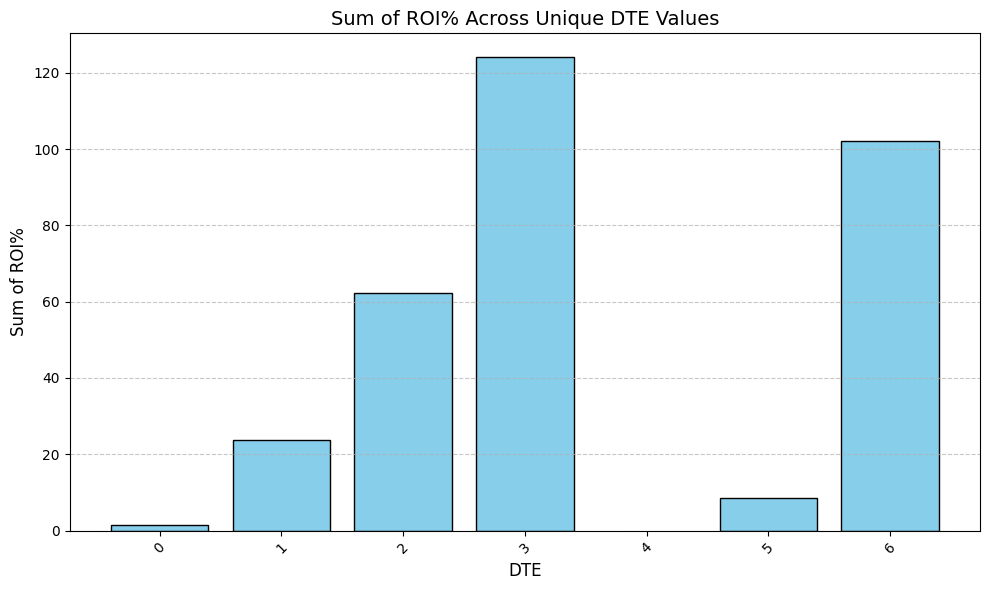

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sum_roi_by_dte(tb):
    """
    Plots the sum of ROI% across all unique DTE values.

    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    """
    # Ensure the DataFrame contains the required columns
    required_columns = {'DTE', 'ROI%'}
    if not required_columns.issubset(tb.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Group by DTE and calculate the sum of ROI%
    result = tb.groupby('DTE', as_index=False)['ROI%'].sum()
    result.rename(columns={'ROI%': 'Sum_ROI%'}, inplace=True)

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(result['DTE'], result['Sum_ROI%'], color='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.title('Sum of ROI% Across Unique DTE Values', fontsize=14)
    plt.xlabel('DTE', fontsize=12)
    plt.ylabel('Sum of ROI%', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
# tb = pd.DataFrame({'DTE': [...], 'ROI%': [...]})  # Replace with your actual DataFrame
plot_sum_roi_by_dte(tb)


In [78]:
def calculate_max_dd(tb):
    """
    Calculates the maximum drawdown for each group of 'DTE'.
    
    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    
    Returns:
    pd.Series: Maximum drawdown for each unique DTE.
    """
    # Calculate cumulative sum of ROI%
    cumulative_returns = tb["ROI%"].cumsum()
    
    # Calculate maximum drawdown
    max_drawdown = (cumulative_returns - cumulative_returns.cummax()).min()
    
    return max_drawdown


/tmp/ipykernel_86248/3694656327.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dd_result = tb.groupby('DTE').apply(calculate_max_dd).reset_index()



Resulting DataFrame:
   DTE  Sum_ROI%  Max_DD%  ROI/DD_Ratio
0    0    1.5300  15.8600        0.1000
1    1   47.8400  17.9300        2.6700
2    2  103.4900  23.0000        4.5000
3    3  200.3800  19.5900       10.2300
4    5    5.8600  15.8200        0.3700
5    6  189.9900  44.0100        4.3200


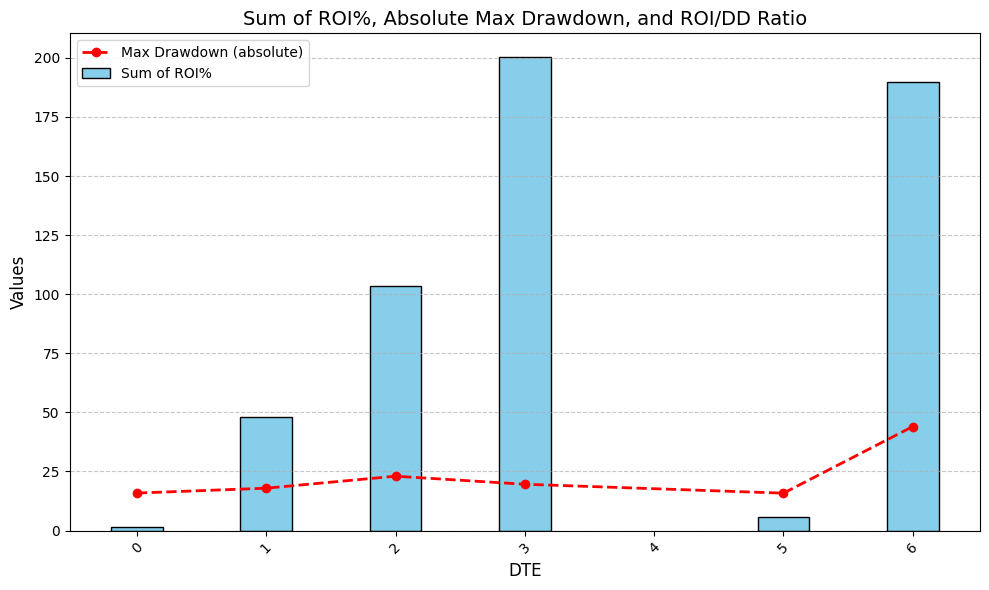

In [79]:
def plot_sum_roi_and_max_dd_by_dte(tb):
    """
    Plots the sum of ROI% and Absolute Max Drawdown (Max DD) across all unique DTE values
    using a single Y-axis, and prints the resulting DataFrame.

    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    """
    # Ensure the DataFrame contains the required columns
    required_columns = {'DTE', 'ROI%'}
    if not required_columns.issubset(tb.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Group by DTE and calculate the sum of ROI%
    roi_result = tb.groupby('DTE', as_index=False)['ROI%'].sum()
    roi_result.rename(columns={'ROI%': 'Sum_ROI%'}, inplace=True)

    # Group by DTE and calculate Max DD (in absolute terms)
    dd_result = tb.groupby('DTE').apply(calculate_max_dd).reset_index()
    dd_result.rename(columns={0: 'Max_DD%'}, inplace=True)
    dd_result['Max_DD%'] = dd_result['Max_DD%'].abs()

    # Merge the sum of ROI% and Max DD data
    result = pd.merge(roi_result, dd_result, on='DTE')

    # Add ROI% / Max DD ratio
    result['ROI/DD_Ratio'] = result.apply(
        lambda row: row['Sum_ROI%'] / row['Max_DD%'] if row['Max_DD%'] != 0 else float('inf'), axis=1
    )

    # Format values
    result['Sum_ROI%'] = result['Sum_ROI%'].round(2)
    result['Max_DD%'] = result['Max_DD%'].round(2)
    result['ROI/DD_Ratio'] = result['ROI/DD_Ratio'].round(2)

    # Print the DataFrame
    print("\nResulting DataFrame:")
    print(result)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Sum of ROI%
    ax.bar(result['DTE'], result['Sum_ROI%'], color='skyblue', edgecolor='black', label='Sum of ROI%', width=0.4, align='center')
    
    # Overlay Max DD (absolute values) on the same axis
    ax.plot(result['DTE'], result['Max_DD%'], color='red', marker='o', label='Max Drawdown (absolute)', linestyle='--', linewidth=2)

    ax.set_xlabel('DTE', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    # Title, legend, and grid
    plt.title('Sum of ROI%, Absolute Max Drawdown, and ROI/DD Ratio', fontsize=14)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    fig.tight_layout()
    plt.show()

plot_sum_roi_and_max_dd_by_dte(tb)
